# Kang LAB summer Workshop: Tutorials for preprocessing 

- Made by Jayoon Choi (Revised 07/11/2023 )
- Reference page: https://lukas-snoek.com/NI-edu/section_intros/4_preprocessing.html
- Data and Code repository: https://github.com/lukassnoek/NI-edu/blob/master/NI-edu/fMRI-introduction/week_4/spike_data.npz

# 1. Simulation of functional preprocesses in the fMRIPrep

In [1]:
import numpy as np
from numpy.linalg import inv
from nilearn.glm.first_level.hemodynamic_models import glover_hrf
from scipy.interpolate import interp1d
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline

/home/sincerely/.conda/envs/nilearn/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


## 1.1. Motion Correction / re-alignment

Rigid body registrations are used tod motion correction in the 4D BOLD data, alignment/registration form BOLD to T1, and Nomalization from T1 to templete(MNI space). 
This method makes sure that all volumes (i.e., 3D fMRI images) are spatially aligned. 

##### Help Functions

In [2]:
from time import sleep
from IPython.display import clear_output

def add_motion_to_vols(vols):
    
    new_vols = np.zeros_like(vols)
    for i in range(new_vols.shape[-1]):
        rot = np.random.uniform(-2, 2, 3)
        trans = np.random.uniform(-0.1, 0.1, 3)
        rot_mat = get_rotation_matrix(*rot)
        trans_mat = get_translation_matrix(*trans)
        center = np.eye(4)
        center[:, -1] = np.r_[np.array(vols.shape[:3]) // 2 - 0.5, 1]
        affine = trans_mat @ center @ rot_mat @ inv(center)
        new_vols[:, :, :, i] = affine_transform(vols[:, :, :, i], matrix=inv(affine))
    return new_vols


def animate_volumes(vols, idx=25, axis=2, show_until=None, to_sleep=0.5, **kwargs):
    if show_until is None:
        show_until = vols.shape[-1]
    
    vols = np.take(vols, idx, axis)
    for i in range(show_until):
        plt.figure(figsize=(8, 8))
        plt.imshow(vols[:, :, i], cmap='gray', **kwargs)
        plt.title("Volume nr. %i" % i, fontsize=(25))
        plt.axis('off')
        plt.show()
        sleep(to_sleep)
        clear_output(wait=True)
def get_translation_matrix(x=0, y=0, z=0):
    """ Computes the translation matrix.
    
    Parameters
    ----------
    x : float
        Translation in the x (first) dimension in voxels
    y : float
        Rotation in the y (second) dimension in voxels
    z : float
        Rotation in the z (third) dimension in voxels
    
    Returns
    -------
    trans_mat : numpy ndarray
        Numpy array of shape 4 x 4
    """
    
    trans_mat = np.eye(4)
    trans_mat[:, -1] = [x, y, z, 1]
    return trans_mat
def get_rotation_matrix(x=0, y=0, z=0):
    """ Computes the rotation matrix.
    
    Parameters
    ----------
    x : float
        Rotation in the x (first) dimension in degrees
    y : float
        Rotation in the y (second) dimension in degrees
    z : float
        Rotation in the z (third) dimension in degrees
    
    Returns
    -------
    rot_mat : numpy ndarray
        Numpy array of shape 4 x 4
    """
    
    x = np.deg2rad(x)
    y = np.deg2rad(y)
    z = np.deg2rad(z)
    
    rot_roll = np.array([
        [1, 0, 0, 0],
        [0, np.cos(x), -np.sin(x), 0],
        [0, np.sin(x), np.cos(x), 0],
        [0, 0, 0, 1]
    ])

    rot_pitch = np.array([
        [np.cos(y), 0, np.sin(y), 0],
        [0, 1, 0, 0],
        [-np.sin(y), 0, np.cos(y), 0],
        [0, 0, 0, 1]
    ])

    rot_yaw = np.array([
        [np.cos(z), -np.sin(z), 0, 0],
        [np.sin(z), np.cos(z), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    rot_mat = rot_roll @ rot_pitch @ rot_yaw
    return rot_mat

from scipy.ndimage import affine_transform

def resample_image(image, trans_mat, rot_mat):
    """ Resamples an image given a translation and rotation matrix.
    
    Parameters
    ----------
    image : numpy array
        A 3D numpy array with image data
    trans_mat : numpy array
        A numpy array of shape 4 x 4
    rot_mat : numpy array
        A numpy array of shape 4 x 4
    
    Returns
    -------
    image_reg : numpy array
        A transformed 3D numpy array
    """
    
    # We need to rotate around the origin, not (0, 0), so
    # add a "center" translation
    center = np.eye(4)
    center[:3, -1] = np.array(image.shape) // 2 - 0.5
    A = center @ trans_mat @ rot_mat @ np.linalg.inv(center)
    
    # affine_transform does "pull" resampling by default, so
    # we need the inverse of A
    image_corr = affine_transform(image, matrix=np.linalg.inv(A))
    
    return image_corr

#### Simulated motion during the scan
Run the section below, and observe how the image changes

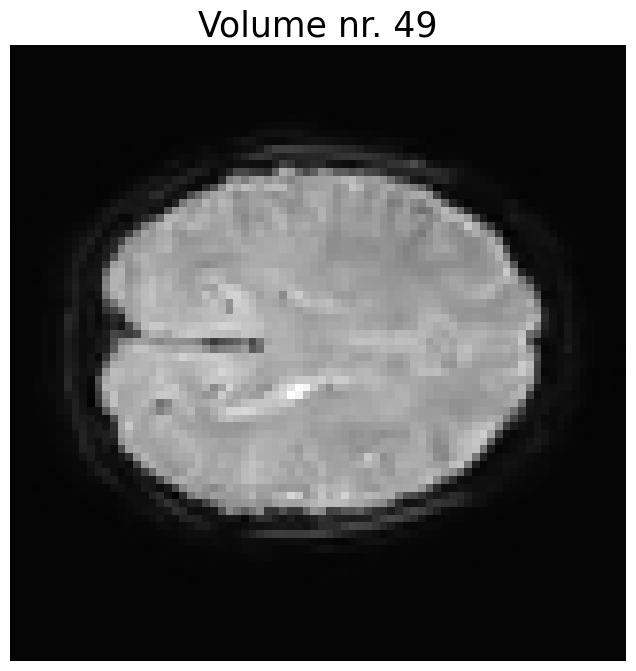

In [79]:
data_4d = nib.load('func.nii.gz').get_fdata()

vols = add_motion_to_vols(data_4d)
animate_volumes(vols)

### 1.1.1. Transformation with the Rigid body registration

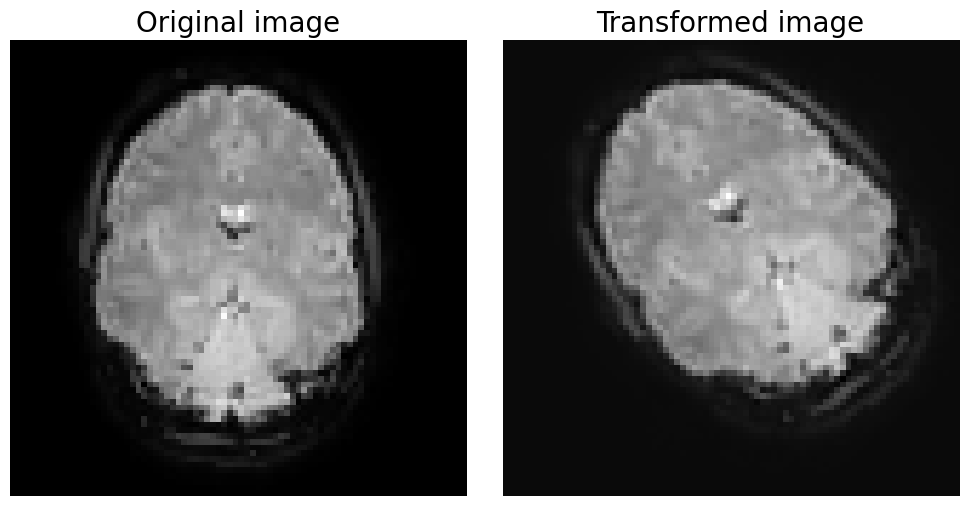

In [4]:
trans_mat = get_translation_matrix(5, 5, 0)
rot_mat = get_rotation_matrix(0, 0, 40)

vols = data_4d
VOL = vols[:, :, :, 0]
PLOT_AXIS = 2
SLICE_IDX = 20

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.take(VOL, SLICE_IDX, PLOT_AXIS).T, origin='lower', cmap='gray')
plt.axis('off')
plt.title('Original image', fontsize=20)

# Resample
vol_res = resample_image(VOL, trans_mat, rot_mat)

plt.subplot(1, 2, 2)
plt.imshow(np.take(vol_res, SLICE_IDX, PLOT_AXIS).T, origin='lower', cmap='gray')
plt.axis('off')
plt.title('Transformed image', fontsize=20)

plt.tight_layout()
plt.show()

#### Practice : Translate image ! 
For this ToDo, you are going to be the optimizer! Below, we have loaded two (brain) images: fixed and moving. Use the resample_image function to translate/rotate the moving image. Make sure you name the output (i.e., the transformed volume) moved. This is then plotted on top of the reference volume to give you an idea of how well your transformation worked. Keep doing this until you're satisfied.
Hint 1: you need rotation in the z dimension and translation in the x and y dimension.
Hint 2: rotation is counter clockwise (if you define negative rotation, e.g. -20, it will be rotated clockwise).

In [5]:
# Load data
with np.load('moco_todo.npz') as moco_data:
    moving = moco_data['moving']
    fixed = moco_data['fixed']

Text(0.5, 1.0, 'fixed image')

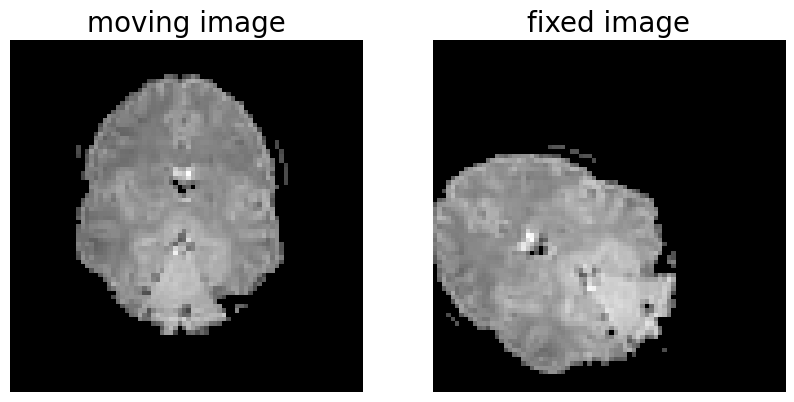

In [6]:
# Present an image set
PLOT_AXIS = 2
SLICE_IDX = 20

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.take(moving, SLICE_IDX, PLOT_AXIS).T, origin='lower', cmap='gray')
plt.axis('off')
plt.title('moving image', fontsize=20)

plt.subplot(1, 2, 2)
plt.imshow(np.take(fixed, SLICE_IDX, PLOT_AXIS).T, origin='lower', cmap='gray')
plt.axis('off')
plt.title('fixed image', fontsize=20)

In [7]:
#fill the CODE! 
trans_mat = get_translation_matrix(-11, -10, 0)
rot_mat = get_rotation_matrix(0, 0, 45)

moved = resample_image(moving, trans_mat, rot_mat)

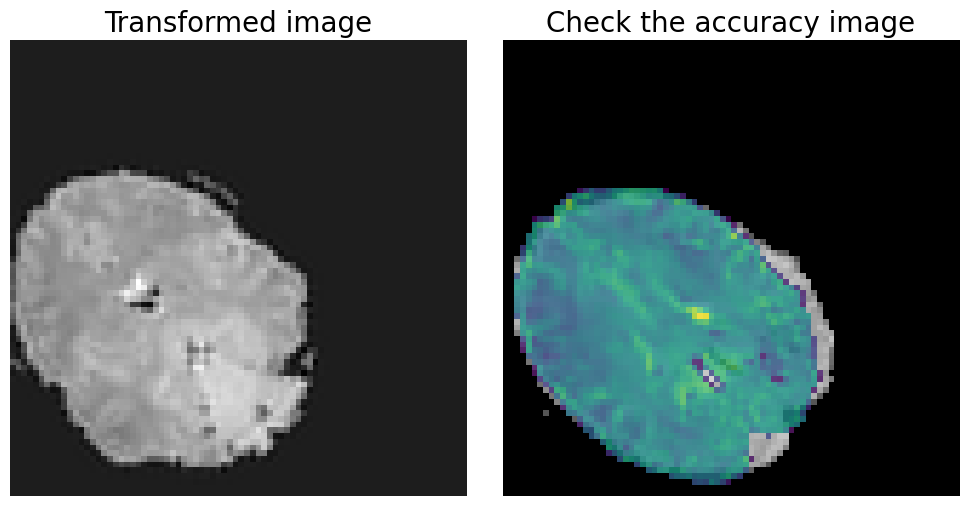

In [8]:
# Check the answer
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.take(moved, SLICE_IDX, PLOT_AXIS).T, origin='lower', cmap='gray')
plt.title('Transformed image', fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(fixed[:, :, 25].T, origin='lower', cmap='gray')
moved4plot = np.ma.masked_where(moved < 2, moved)
plt.imshow(moved4plot[:, :, 25].T, origin='lower', alpha=0.8)
plt.title('Check the accuracy image', fontsize=20)
plt.axis('off')

plt.tight_layout()
plt.show()

## 1.2. Slice-time correction: Resampling 

#### simulated the fMRI data

In [9]:
TR = 2
n_slices = 40
slice_onsets_within_volume = np.linspace(0, TR, n_slices, endpoint=False)
# Note, this would have worked as well: np.arange(0, TR, TR / 40)

print("Length of slice onsets: %i" % slice_onsets_within_volume.size, end='\n\n')
print("Onsets of slices for first volume: %s" % (slice_onsets_within_volume,), end='\n\n')
print("Acquisition of first slice (of first volume) started at %.2f sec." % slice_onsets_within_volume[0])
print("Acquisition of last slice (of first volume) started at %.2f sec." % slice_onsets_within_volume[-1])

Length of slice onsets: 40

Onsets of slices for first volume: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95]

Acquisition of first slice (of first volume) started at 0.00 sec.
Acquisition of last slice (of first volume) started at 1.95 sec.


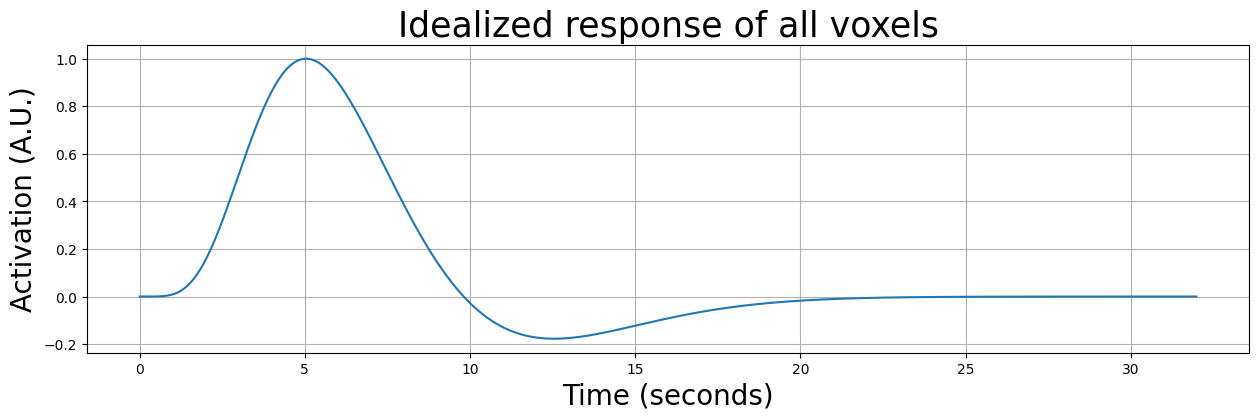

In [10]:
oversampling = 100
exp_length = 32
n_vols = 32 // TR

ideal_response = glover_hrf(tr=TR, time_length=exp_length, oversampling=TR * oversampling)
ideal_response /= ideal_response.max()
t = np.linspace(0, exp_length, ideal_response.size, endpoint=False)

plt.figure(figsize=(15, 4))
plt.plot(t, ideal_response)
plt.grid()
plt.title("Idealized response of all voxels", fontsize=25)
plt.xlabel("Time (seconds)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.show()

### Resampling for correcting 

In [11]:
dt = TR / n_slices
slice_num = 23

# note the slice_num - 1, as Python uses 0-based indexing
start = dt * (slice_num - 1)
end = exp_length + dt * (slice_num - 1)
onsets_slice23_across_volumes = np.linspace(start, end, n_vols, endpoint=False) # onsets_slice_across_volumes = np.linspace(dt * slice_num, length_exp + dt * slice_num, n_vols, endpoint=False)
print(onsets_slice23_across_volumes)

[ 1.1  3.1  5.1  7.1  9.1 11.1 13.1 15.1 17.1 19.1 21.1 23.1 25.1 27.1
 29.1 31.1]


Onset acquisition of slice 0 (first 10 volumes): [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Onset acquisition of slice 20 (first 10 volumes): [ 0.95  2.95  4.95  6.95  8.95 10.95 12.95 14.95 16.95 18.95]


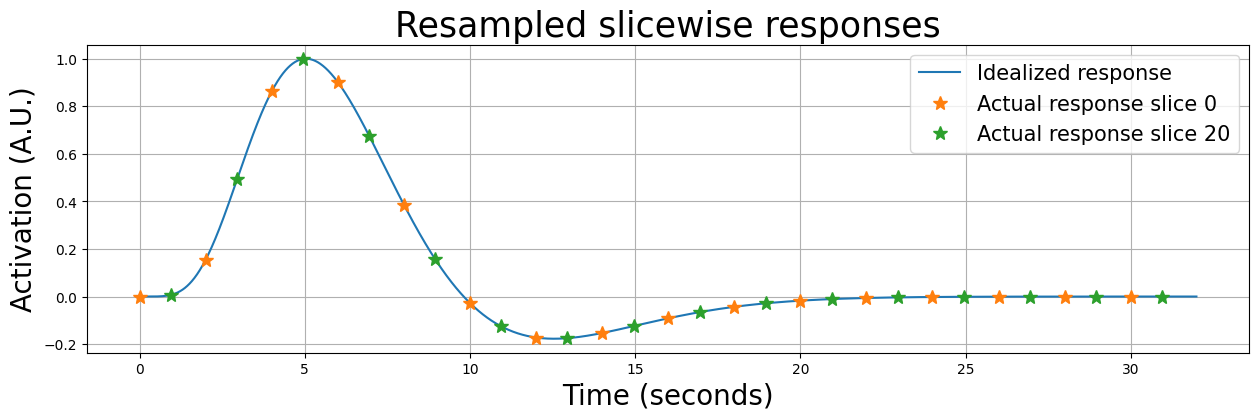

In [12]:
onsets_s0_across_volumes = np.linspace(0, exp_length, n_vols, endpoint=False)
onsets_s20_across_volumes = np.linspace(dt * 19, exp_length + dt * 19, n_vols, endpoint=False)

print("Onset acquisition of slice 0 (first 10 volumes): %s" % (onsets_s0_across_volumes[:10],))
print("Onset acquisition of slice 20 (first 10 volumes): %s" % (onsets_s20_across_volumes[:10],))

# "Fit" the interpolation 
resampler = interp1d(t, ideal_response)

plt.figure(figsize=(15, 4))
plt.plot(t, ideal_response)
plt.grid()
plt.title("Resampled slicewise responses", fontsize=25)
plt.xlabel("Time (seconds)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)

for onsets in [onsets_s0_across_volumes, onsets_s20_across_volumes]:
    # Do not use this code as an example to solve the next ToDo!
    # Because it does it the other way around.
    slice_sig = resampler(onsets)  # resample to slice times! kind of like inverse slice-time correction
    plt.plot(onsets, slice_sig, marker='*', ls='None', ms=10)

plt.legend(['Idealized response', 'Actual response slice 0', 'Actual response slice 20'],
           fontsize=15)
plt.show()

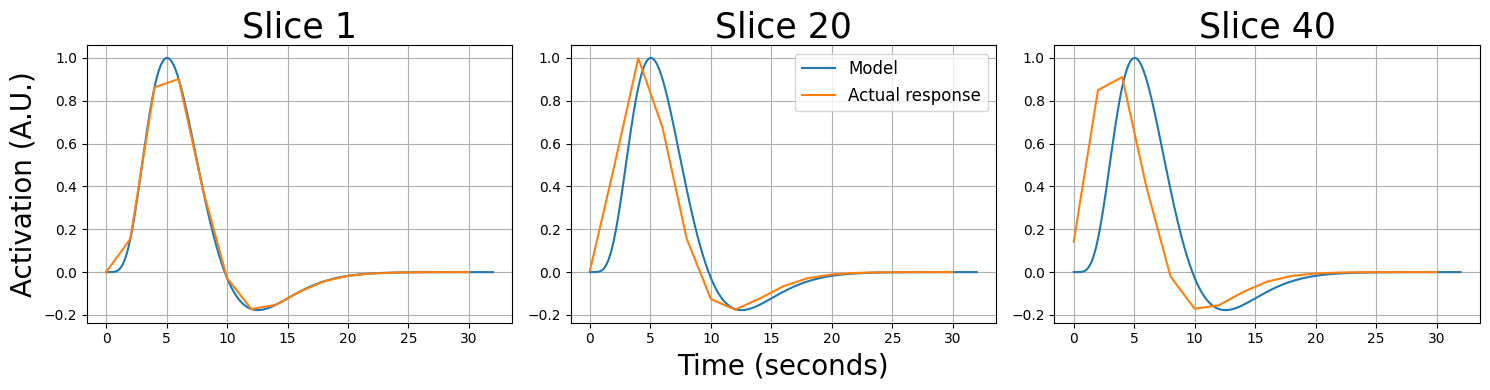

In [13]:
plt.figure(figsize=(15, 4))

slice_data = np.zeros((slice_sig.size, 3))
slice_onsets_across_volumes = np.zeros((slice_sig.size, 3))
for i, slc in enumerate([0, 19, 39]):
    t_slice = np.linspace(dt * slc, exp_length + dt * slc, n_vols, endpoint=False)
    slice_resp = resampler(t_slice)
    slice_data[:, i] = slice_resp  # save for later
    slice_onsets_across_volumes[:, i] = t_slice
    plt.subplot(1, 3, i+1)
    plt.plot(t, ideal_response)
    plt.plot(onsets_s0_across_volumes, slice_resp)
    plt.title("Slice %i" % (slc + 1), fontsize=25)
    plt.grid()
    
    if i == 0:
        plt.ylabel("Activation (A.U.)", fontsize=20)
    
    if i == 1:
        plt.xlabel("Time (seconds)", fontsize=20)
        plt.legend(['Model', 'Actual response'], fontsize=12)

plt.tight_layout()
plt.show()

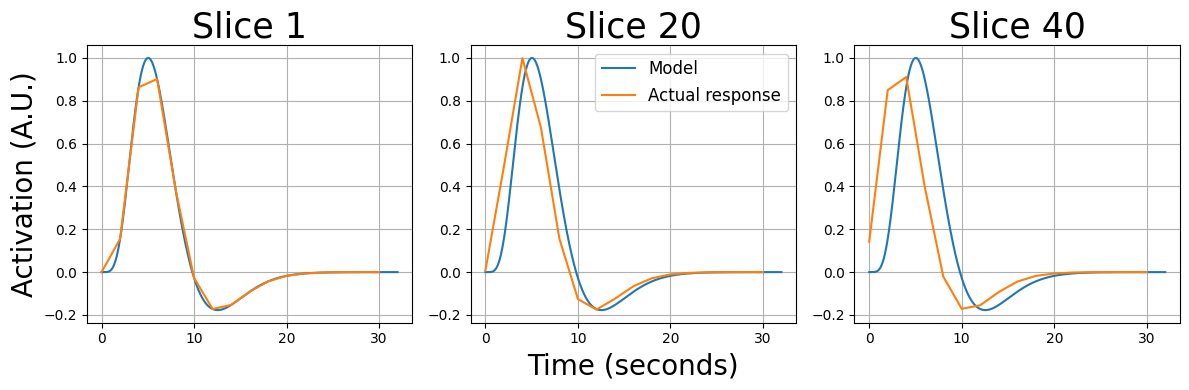

In [14]:
plt.figure(figsize=(12, 4))

slice_data = np.zeros((slice_sig.size, 3))
slice_onsets_across_volumes = np.zeros((slice_sig.size, 3))
for i, slc in enumerate([0, 19, 39]):
    t_slice = np.linspace(dt * slc, exp_length + dt * slc, n_vols, endpoint=False)
    slice_resp = resampler(t_slice)
    slice_data[:, i] = slice_resp  # save for later
    slice_onsets_across_volumes[:, i] = t_slice
    plt.subplot(1, 3, i+1)
    plt.plot(t, ideal_response)
    plt.plot(onsets_s0_across_volumes, slice_resp)
    plt.title("Slice %i" % (slc + 1), fontsize=25)
    plt.grid()
    
    if i == 0:
        plt.ylabel("Activation (A.U.)", fontsize=20)
    
    if i == 1:
        plt.xlabel("Time (seconds)", fontsize=20)
        plt.legend(['Model', 'Actual response'], fontsize=12)

plt.tight_layout()
plt.show()

# 2. Simulation about Denoising 
- After finising fMRIPrep, there are still some preprocess steps. 
- These steps are optional but recomanded to do before analysis. 
- Along to your study or previous study, you can decide to include which correction in your denoising preprocessing. 

## 2.1. Optional Spatial Preprocess : Blurring & Smoothing
for better SNR(Signal to Noise) 

In [15]:
# import some functionality
import os.path as op
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

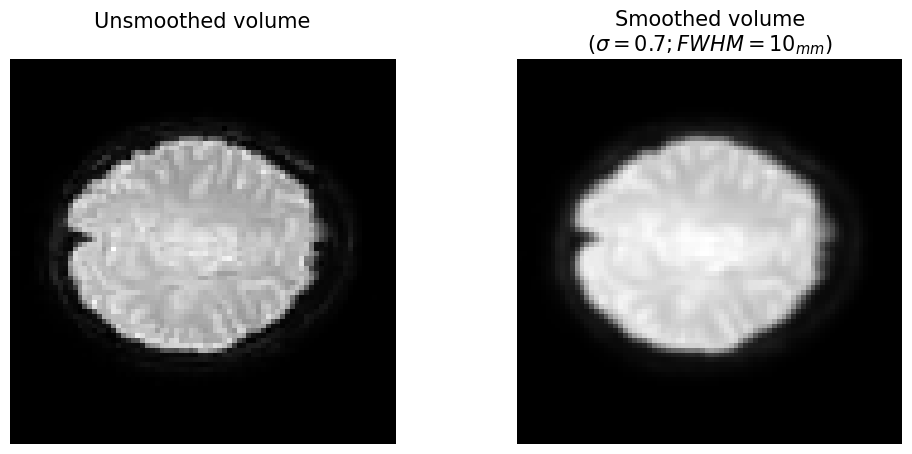

In [16]:
data_4d = nib.load('func.nii.gz').get_fdata()
vol = data_4d[:, :, :, 20] # We'll pick the 21st volume (Python is 0-indexed, remember?)

fwhm = 10
voxelsize = 6

sigma = fwhm / (np.sqrt(8 * np.log(2)) * voxelsize)
smoothed_vol = gaussian_filter(vol, sigma=sigma)

# Let's plot both the unsmoothed and smoothed volume
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(vol[:, :, 30], cmap='gray') # And we'll pick the 11th axial slice to visualize
plt.axis('off')
plt.title("Unsmoothed volume\n", fontsize=15)

plt.subplot(1, 2, 2)
plt.imshow(smoothed_vol[:, :, 30], cmap='gray')
plt.axis('off')
plt.title('Smoothed volume\n($\sigma = %.1f; FWHM = %s_{mm}$)' % (sigma, fwhm), fontsize=15)
plt.show()

## 2.2. Optional Temporal Preprocess : High-pass filtering of fMRI data

### 2.2.1. (option 1) Manipulating the signal (y) directly
- By using high-pass filter, you can remove the low-frequency signals such like the slow drift.
- It makes your model better fit 

#### Help functions

In [17]:
# Help Functions 
from nilearn.glm.first_level.hemodynamic_models import glover_hrf, glover_time_derivative
from scipy.linalg import toeplitz

def simulate_signal(onsets, conditions, TR=2, duration=None, icept=0, params_canon=None, params_tderiv=None,
                    params_deriv1=None, phi=None, std_noise=1, osf=100, rnd_seed=None, plot=True):
    """ Simulates a somewhat realistic voxel signal with an associated design matrix. """
    if rnd_seed is not None:
        np.random.seed(rnd_seed)
    
    conds = sorted(np.unique(conditions))
    P = len(conds)
    
    if duration is None:
        duration = np.max(onsets) + 30
    
    if params_canon is None:
        params_canon = np.zeros(P)

    # TMP FIX
    params_tderiv = params_deriv1
    
    if params_tderiv is None:
        params_tderiv = np.zeros(P)

    X = np.zeros((duration * osf, P))
    for ons, con in zip(onsets, conditions):
        X[int(ons * osf), conds.index(con)] = 1
        
    hrf = glover_hrf(tr=1, oversampling=osf)
    hrf_d = glover_time_derivative(tr=1, oversampling=osf)

    t_orig = np.arange(0, duration, 1 / osf)
    t_new = np.arange(0, duration, TR)
    
    Xconv = np.zeros((t_orig.size, P * 2))
    idx = 0
    for i, this_hrf in enumerate([hrf, hrf_d]):
        this_hrf /= this_hrf.max()
        for ii in range(P):
            Xconv[:, idx] = np.convolve(X[:, ii], this_hrf)[:t_orig.size]  
            idx += 1
    
    Xconv = np.c_[np.ones(Xconv.shape[0]), Xconv]
    params = np.r_[icept, params_canon, params_tderiv]
    y = Xconv @ params
    
    resampler = interp1d(t_orig, y)
    y = resampler(t_new)       
    
    if phi is None:
        noise_cov = std_noise ** 2 * np.eye(y.size)
    else:
        noise_cov = std_noise ** 2 * phi ** toeplitz(np.arange(y.size))
    
    y = y + np.random.multivariate_normal(np.zeros(y.size), noise_cov)

    Xconv_ds = np.zeros((t_new.size, Xconv.shape[1]))
    for i in range(Xconv.shape[1]):
        resampler = interp1d(t_orig, Xconv[:, i])
        Xconv_ds[:, i] = resampler(t_new)
    
    est_betas = np.linalg.lstsq(Xconv_ds, y, rcond=None)[0]
    if plot:
        plt.figure(figsize=(15, 5))
        plt.plot(y)
        plt.plot(Xconv_ds @ est_betas)
        plt.xlim(0, y.size)
        plt.legend(['y', 'y-hat'])
        plt.show()

    return y, Xconv_ds

#### Simulated fMRI data

Shape of X: (300, 2)
Shape of y (sig): (300,)


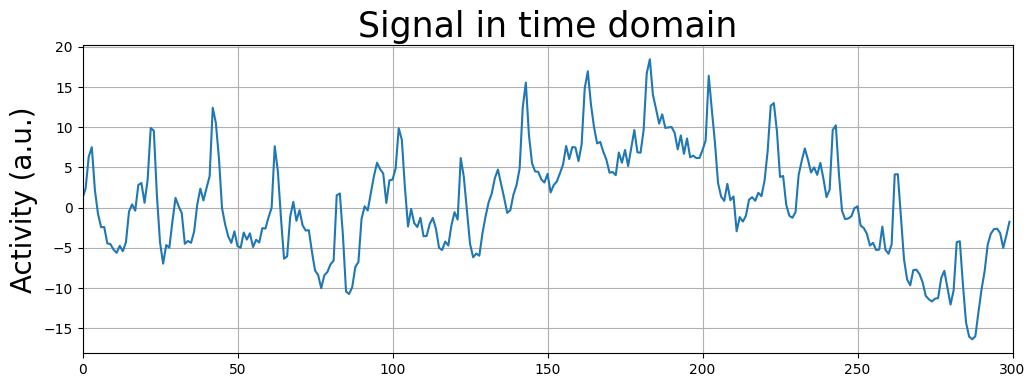

In [29]:
# Freqeuncy Charateristics of fMRI data
onsets = np.arange(0, 600, 40)
sig, X = simulate_signal(
    onsets,
    ['stim'] * onsets.size,
    duration=600,
    TR=2,
    icept=0,
    params_canon=[10],
    std_noise=5,
    rnd_seed=29,
    phi=0.95,
    plot=False
)
X = X[:, :-1]  # trim off the temporal derivative

print("Shape of X: %s" % (X.shape,))
print("Shape of y (sig): %s" % (sig.shape,))

plt.figure(figsize=(12, 4))
plt.plot(sig)
plt.xlim(0, sig.size)
plt.title('Signal in time domain', fontsize=25)
plt.ylabel('Activity (a.u.)', fontsize=20)
plt.grid()


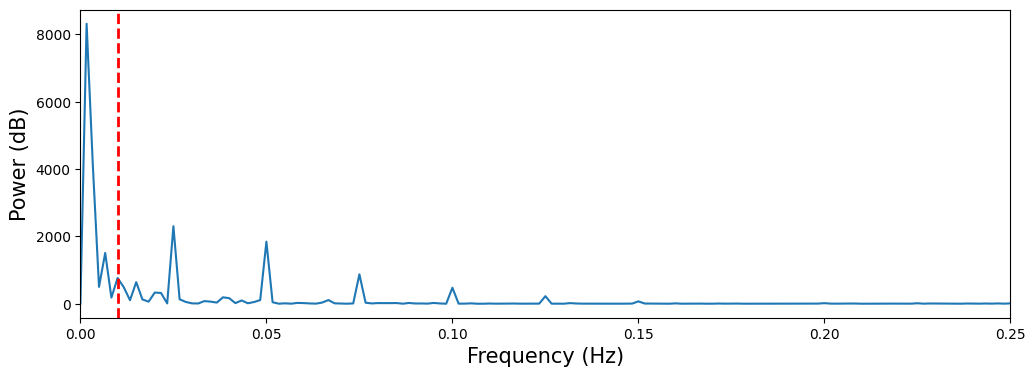

In [30]:
from scipy.signal import periodogram
# Plotting slow drift components (which are approximately below 0.01 Hz-left of the dashed red line).
plt.figure(figsize=(12, 4))
TR = 2
sampling_frequency = 1 / TR  # our sampling rate is 0.5, because our TR is 2 sec!
freq, power = periodogram(sig, fs=0.5)
plt.plot(freq, power)
plt.xlim(0, freq.max())
plt.xlabel('Frequency (Hz)', fontsize=15)
plt.ylabel('Power (dB)', fontsize=15)
plt.axvline(x=0.01,color='r',ls='dashed', lw=2)

plt.show()

#### Filtering high-frequency

Below, we estimate the low-frequency component using the high-pass filter first and plot it together with the original signal, 
which shows that it accurately captures the low-frequency drift (upper plot). 
Then, we subtract the low-frequency component from the original signal to create the filtered signal, 
and plot it together with the original signal to highlight the effect of filtering (lower plot):

In [31]:
print(sig.shape)

(300,)


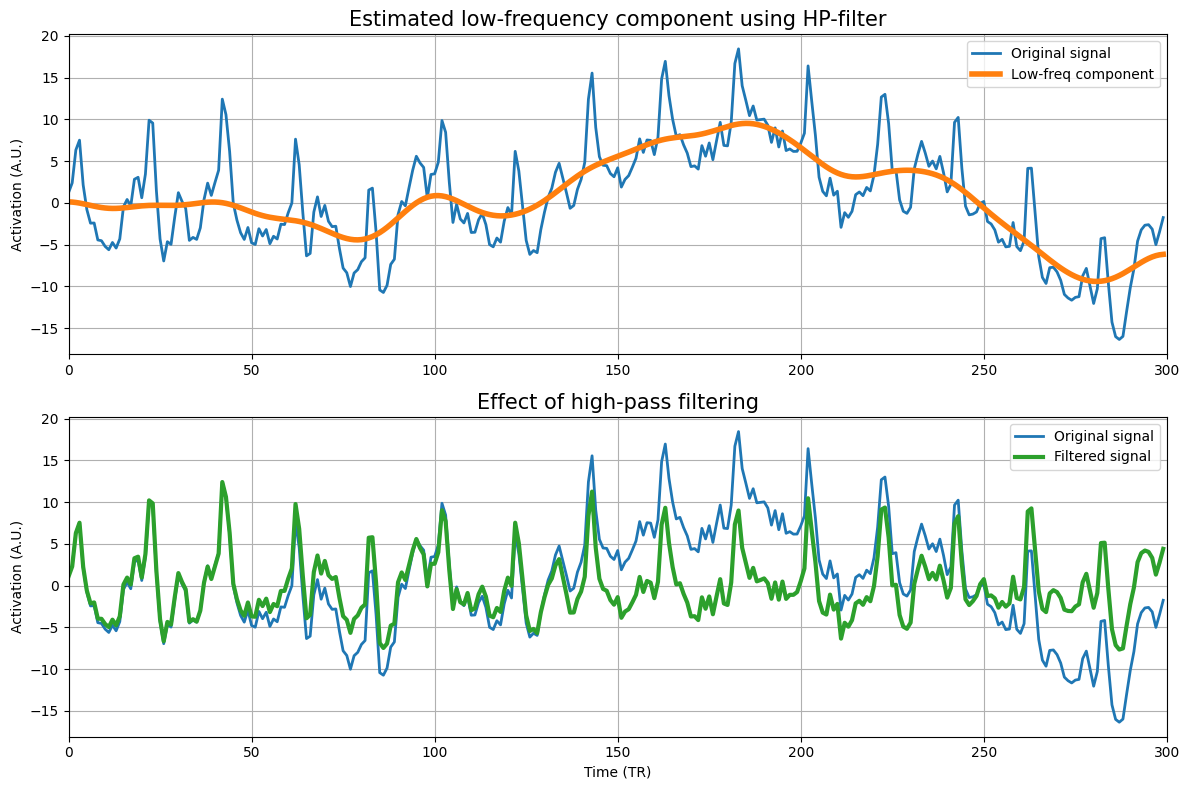

In [32]:
from scipy.ndimage import gaussian_filter

filt = gaussian_filter(sig, 8.5) # high-pass filter 

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(sig, lw=2)
plt.plot(filt, lw=4)
plt.xlim(0, sig.size)
plt.legend(['Original signal', 'Low-freq component'], fontsize=10)
plt.title("Estimated low-frequency component using HP-filter", fontsize=15)
plt.ylabel("Activation (A.U.)", fontsize=10)
plt.grid()

# IMPORTANT: subtract filter from signal
filt_sig = sig - filt

plt.subplot(2, 1, 2)
plt.plot(sig, lw=2)
plt.plot(filt_sig, lw=3, c='tab:green')
plt.xlim(0, sig.size)
plt.legend(['Original signal', 'Filtered signal'], fontsize=10)
plt.title("Effect of high-pass filtering", fontsize=15)
plt.xlabel("Time (TR)", fontsize=10)
plt.ylabel("Activation (A.U.)", fontsize=10)
plt.grid()

plt.tight_layout()
plt.show()

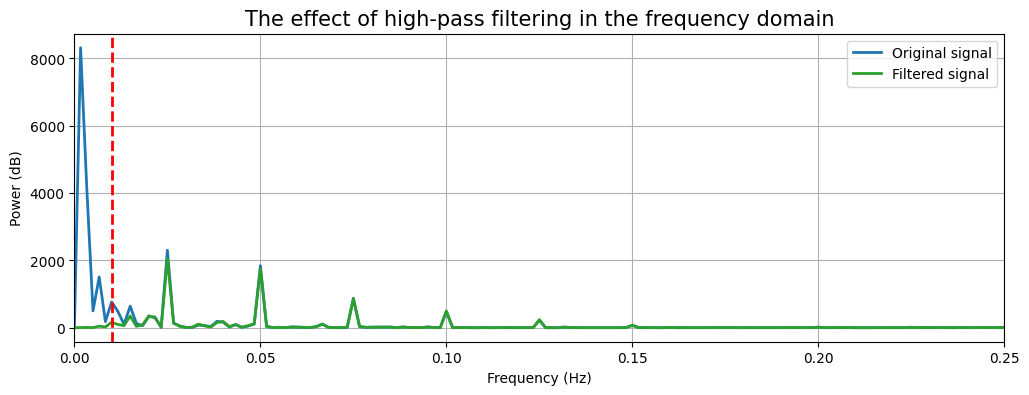

In [33]:
plt.figure(figsize=(12, 4))

freq, power = periodogram(sig, fs=0.5)
plt.plot(freq, power, lw=2)

freq, power = periodogram(filt_sig, fs=0.5)
plt.plot(freq, power, lw=2, c='tab:green')

plt.xlim(0, freq.max())
plt.ylabel('Power (dB)', fontsize=10)
plt.xlabel('Frequency (Hz)', fontsize=10)
plt.title("The effect of high-pass filtering in the frequency domain", fontsize=15)
plt.legend(["Original signal", "Filtered signal"], fontsize=10)
plt.axvline(x=0.01,color='r',ls='dashed', lw=2)
plt.grid()

plt.show()

#### ToDo Practice
So far, we’ve filtered only a single (simulated) voxel timeseries. 
Normally, you want to temporally filter all your voxels in your 4D fMRI data, of course. 
Below, we load in such a 4D fMRI file (data_4d), which has 50 timepoints and (80 * 80 * 44) = 281600 voxels.

For this assignment, you need to apply the high-pass filter (i.e., the gaussian_filter function; use sigma=25) 
on each and every voxel separately, which means that you need to loop through all voxels (which amounts to three nested for-loops across all three spatial dimensions). 
Make data_4d_filt variable (the loop may, if implemented correctly, take about 20 seconds!).

Importantly, the gaussian filter does not return the filtered signal itself, but the estimated low-frequency component of the data. As such, to filter the signal, we have to subtract this low-frequency component from the original signal to get the filtered signal!

In [35]:
import os.path as op
import nibabel as nib

data_4d = nib.load('func.nii.gz').get_fdata()

print("Shape of the original 4D fMRI scan: %s" % (data_4d.shape,))

# Here, we pre-allocate a matrix of the same shape as data_4d, in which
# you need to store the filtered timeseries
data_4d_filt = np.zeros(data_4d.shape)

# YOUR CODE HERE
for t in np.arange(data_4d.shape[3]):
    for x, y, z in zip(np.arange(data_4d.shape[0]), np.arange(data_4d.shape[1]), np.arange(data_4d.shape[2])):
        sig = data_4d[x,y,z,:]
        filt =gaussian_filter(sig, 25)
        # IMPORTANT: subtract filter from signal
        data_4d_filt[x, y, z, :] = sig - filt

Shape of the original 4D fMRI scan: (80, 80, 44, 50)


In [36]:
''' Tests the above ToDo. '''
# Test some random indices
np.testing.assert_almost_equal(data_4d_filt[20, 20, 20, 20], -1366.2907714, decimal=3)
np.testing.assert_almost_equal(data_4d_filt[30, 30, 30, 30], -381.6953125, decimal=3)
np.testing.assert_almost_equal(data_4d_filt[40, 40, 40, 40], -269.359375, decimal=3)
# 오답이면 에러가 뜹니다

### 2.2.2. (Option 2) Including “noise predictors” in your design (X) 

Another way to reduce the noise term is to include noise regressors (also called ‘nuisance variables/regressors’) in the design matrix. As such, we can subdivide our design matrix into “predictors of interest” (which are included to model the task/stimuli) and “noise predictors” (which aim to model the thus-far unmodelled variance). These “noise predictors” are also sometimes called “nuisance” predictors/regressors/covariates.

One example of this (with respect to high-pass filtering) is including a series of cosines with varying frequencies in your design, which have the same effect as a high-pass filter. This type of filter is called a “discrete cosine (basis) set”. 

In [37]:
from nilearn.glm.first_level.design_matrix import _cosine_drift as discrete_cosine_transform

onsets = np.arange(0, 600, 40)
sig, X = simulate_signal(
    onsets,
    ['stim'] * onsets.size,
    duration=600,
    TR=2,
    icept=0,
    params_canon=[10],
    std_noise=5,
    rnd_seed=29,
    phi=0.95,
    plot=False
)
X = X[:, :-1]  # trim off the temporal derivative


frame_times = np.linspace(0, 600, 300, endpoint=False)   # Onset timepoints of 600 secs & 2TR ] 
dc_set = discrete_cosine_transform(high_pass=0.01, frame_times=frame_times)  #
dc_set = dc_set[:, :-1]  # remove the (extra) intercept
print(sig.shape)
print(dc_set.shape)
print(X.shape)

(300,)
(300, 12)
(300, 2)


#### An example of discrete cosine set

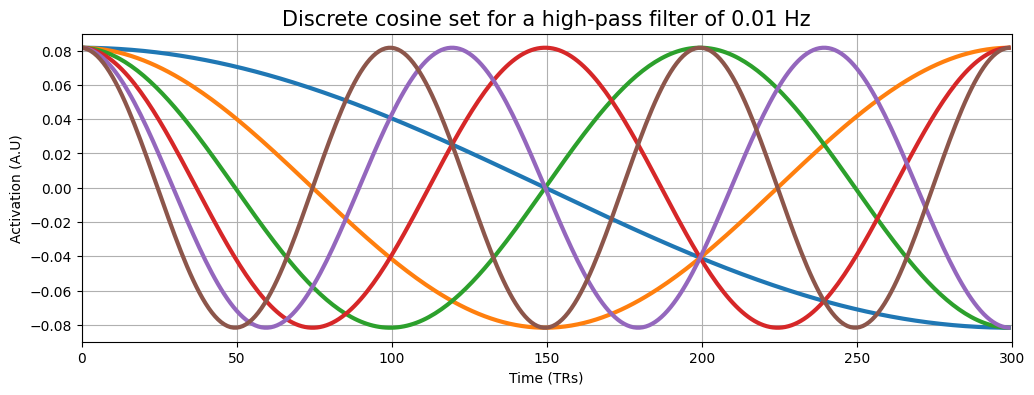

In [38]:
plt.figure(figsize=(12, 4))
plt.plot(dc_set[:, :6], lw=3)
plt.xlim(0, sig.size)
plt.grid()
plt.title("Discrete cosine set for a high-pass filter of 0.01 Hz", fontsize=15)
plt.xlabel("Time (TRs)", fontsize=10)
plt.ylabel("Activation (A.U)", fontsize=10)
plt.show()

#### Practice 
Add the discrete cosine set as predictors to the design (X) and store it in a new variable named X_dct (do *not* overwrite the X variable). 
Make sure the first two columns of X_dct are the original predictors from X followed by the DCT set. 
Then, run linear regression. Save the parameters ("betas") in a variable named betas_dct. 
Plot the predicted signal ($\hat{\mathbf{y}}$) and the signal (sig) in the same plot. Name the axis labels appropriately.

In [39]:
X_dct = np.concatenate((X,dc_set),axis=1)
print(X_dct.shape)

betas_dct = inv(X_dct.T @ X_dct) @ X_dct.T @ sig
betas_dct = betas_dct.squeeze()

(300, 14)


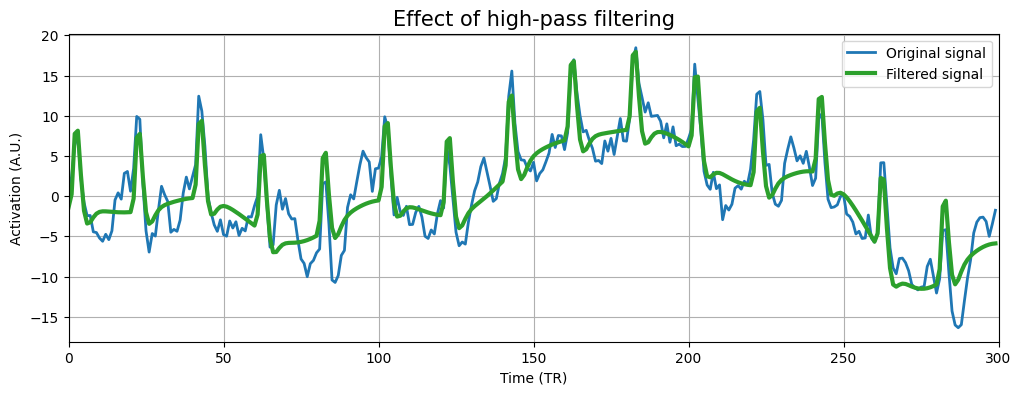

In [40]:
# Freqeuncy Charateristics of fMRI data
yhat_dct =  X_dct @ betas_dct

plt.figure(figsize=(12, 4))

#plt.plot(X, lw=2, c='tab:orange')
plt.plot(sig, lw=2, c='tab:blue')
plt.plot(yhat_dct, lw=3, c='tab:green')
plt.xlim(0, sig.size)
plt.legend(['Original signal', 'Filtered signal'], fontsize=10)
plt.title("Effect of high-pass filtering", fontsize=15)
plt.xlabel("Time (TR)", fontsize=10)
plt.ylabel("Activation (A.U.)", fontsize=10)
plt.grid()

### 2.2.3. Using nuisance regression for de-spiking

Spikes reflect sudden large intensity increases in the signal across the entire brain that likely reflect scanner instabilities. 
One way to deal with these artifacts is to “censor” bad timepoints (containing the spike) in your signal using a noise predictor.

By imposing some threshold above, a timepoint is marked as a spike (technically, it’s a little bit more complex, but we’ll ignore that for now).

#### a (simulated) 4D fMRI scan 
- voxels and 500 timepoints (assuming a TR of 2, this amounts to a duration of 1000 seconds). 

Shape of all_sig: (10, 10, 10, 500)
Shape of pred: (500, 1)


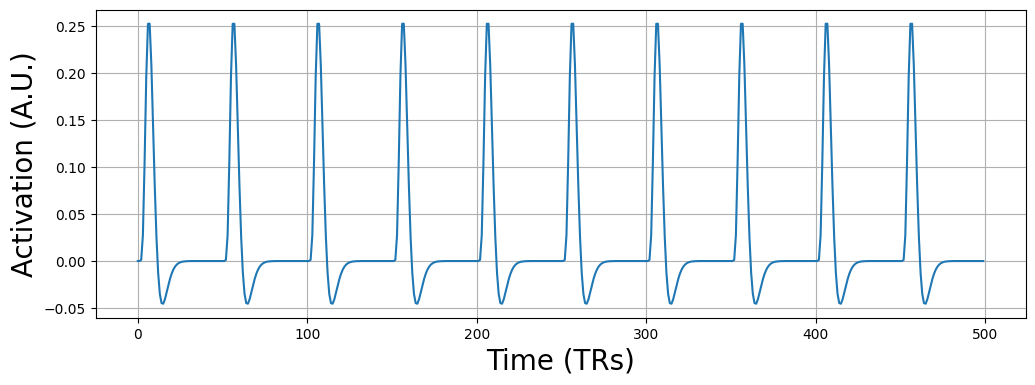

In [41]:
# A simulation of data (y, all_sig) and predictors(X, pred)
with np.load('spike_data.npz') as spike_data:
    all_sig = spike_data['all_sig']
    pred = spike_data['pred']

print("Shape of all_sig: %s" % (all_sig.shape,))
print("Shape of pred: %s" % (pred.shape,))

plt.figure(figsize=(12, 4))
plt.plot(pred)
plt.grid()
plt.xlabel('Time (TRs)', fontsize=20)
plt.ylabel('Activation (A.U.)', fontsize=20)
plt.show()

#### Calculating “Successive differences” 

This quantity reflects the difference between every timepoint t of your signal and the signal at timepoints t-1, which is then squared, averaged (across all voxels, 1 ... K).

In [44]:
ex_sig = np.array([1, 3, -2, 0, 5])
succ_diff = ex_sig[1:] - ex_sig[:-1]
print(ex_sig[1:])
print(ex_sig[:-1])
print(succ_diff)


[ 3 -2  0  5]
[ 1  3 -2  0]
[ 2 -5  2  5]


In [45]:
succ_diff = np.insert(succ_diff, 0, ex_sig[0])
print(succ_diff)

[ 1  2 -5  2  5]


#### calculating "RMSSD"
what defines a ‘spike’/bad timepoint? One way is to compute the normalized “root mean square successive differences” (RMSSD), normalizing this, and imposing some threshold above which a timepoint is marked as a spike (technically, it’s a little bit more complex, but we’ll ignore that for now).

In [61]:
#calculate RMSSD at a single volxel 
rmssd = np.sqrt(np.sum((succ_diff)**2)/1)
rmssd

7.681145747868608

#### Practice - help me....


Compute the successive difference of the data. Note that our data (all_sig) has 4 dimensions, with the fourth dimension representing time. 
Store the result in a variable named all_sig_rmssd, which should have the same shape as the original signal. 
Also, try to do this without a for-loop by making using of vectorization.

In [54]:
prac = all_sig_rmssd[1,1,1,:]
prac = np.insert(prac, 0, all_sig[1,1,1,0], axis = 0)
all_sig[:,:,:,0].reshape((10,10,10,1)).shape

(10, 10, 10, 1)

In [72]:
range(all_sig_succ_diff.shape[3])

range(0, 500)

In [75]:
all_sig_succ_diff = all_sig[:,:,:,1:] - all_sig[:,:,:,:-1]
print(all_sig_succ_diff.shape)

all_sig_succ_diff = np.insert(all_sig_succ_diff, 0, all_sig_succ_diff[:,:,:,0], axis = 3)
print(all_sig_succ_diff.shape)

all_sig_rmssd = np.zeros(all_sig_succ_diff.shape[3])
for t in range(all_sig_succ_diff.shape[3]):
    sig = all_sig_succ_diff[:,:,:,t]
    all_sig_rmssd[t] = np.sqrt(np.sum((sig)**2)/1000)
print(all_sig_rmssd.shape)

z_rmssd = (all_sig_rmssd - np.mean(all_sig_rmssd)) / np.std(all_sig_rmssd)

identified_spikes = z_rmssd > 7  # creates array with True/False
n_spike = identified_spikes.sum()
print("There are %i spikes in the data!" % n_spike)

(10, 10, 10, 499)
(10, 10, 10, 500)
(500,)
There are 2 spikes in the data!


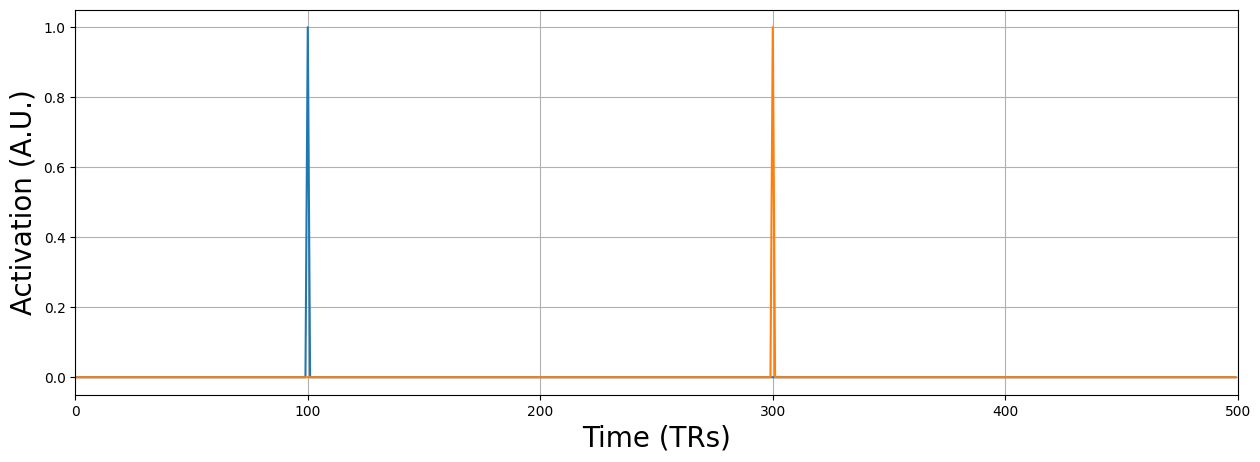

In [76]:
spike_pred = np.zeros((pred.size, n_spike))

t_spikes = np.where(identified_spikes)[0]
for i, t in enumerate(t_spikes):
    #print("Creating spike predictor for t = %i" % t)
    spike_pred[t, i] = 1

plt.figure(figsize=(15, 5))
plt.plot(spike_pred)
plt.xlabel("Time (TRs)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.grid()
plt.xlim(0, pred.size)
plt.show()

### 2.2.4. nuisance regression: Motion filtering 
Motion filtering corrects that the head movement itself affected the functional data signal strength.
Six motion parameters are obtained to determine how much head movement was on the data. 

- Even after motion realignment, your data is still ‘contaminated’ by motion.
- one popular approach is to simply add the 6 realignment parameters (rotation and translation in 3 directions) to the design-matrix. 
- In other words, we treat the motion realignment parameters as “nuisance regressors” that are aimed to explain activity that is related to motion.

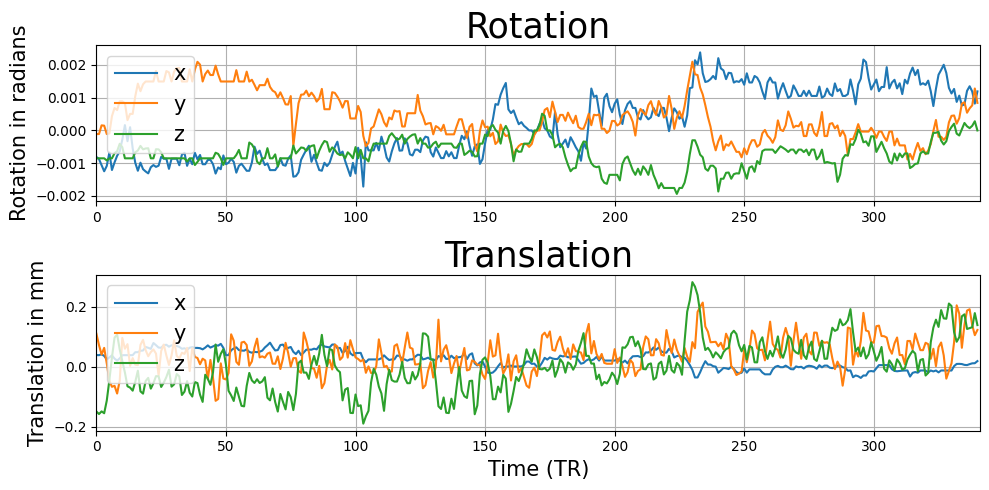

In [77]:
""" This data has been motion-corrected using the FSL tool 'MCFLIRT', which outputs a file
ending in *.par that contains the 6 motion parameters (rotation/translation in 3 directions each).
We'll load in this file and plot these motion parameters. """

motion_params = np.loadtxt('func_motion_pars_new.txt')
rotation_params = motion_params[:, :3]
translation_params = motion_params[:, 3:]

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.title('Rotation', fontsize=25)
plt.plot(rotation_params)
plt.xlim(0, motion_params.shape[0])
plt.legend(['x', 'y', 'z'], fontsize=15)
plt.ylabel('Rotation in radians', fontsize=15)
plt.grid()

plt.subplot(2, 1, 2)
plt.title('Translation', fontsize=25)
plt.plot(translation_params)
plt.legend(['x', 'y', 'z'], fontsize=15)
plt.ylabel('Translation in mm', fontsize=15)
plt.xlim(0, motion_params.shape[0])
plt.xlabel('Time (TR)', fontsize=15)
plt.grid()

plt.tight_layout()
plt.show()

#### Head motion estimation and Confounds estimation

In [78]:
# Calculating framewise displacement(FD) 
fd_trace = np.empty(motion_params.shape[0])
for x in np.arange(1,motion_params.shape[0]-1):
    rot_fd = np.abs(rotation_params[x+1, :] - rotation_params[x, :])*50
    trans_fd = np.abs(translation_params[x+1, :] - translation_params[x, :])*50
    fd = np.sum(np.concatenate((rot_fd, trans_fd)))
    fd_trace[x] = fd
    fd_trace[0] = 0 

mean_fd = np.mean(fd_trace)
std_fd = np.std(fd_trace)

print('mean of FD: ', mean_fd, ' std of FD: ', std_fd)

mean of FD:  3.7872788371421144  std of FD:  2.0473549505384114
